In [27]:
import numpy as np
import pandas as pd
from typing import Mapping, List, Tuple
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
    load_breast_cancer, load_diabetes, fetch_mldata
from  matplotlib.collections import LineCollection
import time
from pandas.api.types import is_string_dtype, is_object_dtype, is_categorical_dtype, is_bool_dtype
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from pdpbox import pdp
from rfpimp import *
from scipy.integrate import cumtrapz
from scipy.special import expit

from mine.plot import *
from mine.ice import *

def df_string_to_cat(df:pd.DataFrame) -> dict:
    catencoders = {}
    for colname in df.columns:
        if is_string_dtype(df[colname]) or is_object_dtype(df[colname]):
            df[colname] = df[colname].astype('category').cat.as_ordered()
            catencoders[colname] = df[colname].cat.categories
    return catencoders

def df_cat_to_catcode(df):
    for col in df.columns:
        if is_categorical_dtype(df[col]):
            df[col] = df[col].cat.codes + 1

In [105]:
df = pd.DataFrame()
a,b = -5,5
n = 20
df['x1'] = np.linspace(a,b,n-1)
df['y']  = np.where(df['x1'].values<0, 0, 1)
df

,x1,y
0,-5.000000,0
1,-4.444444,0
2,-3.888889,0
3,-3.333333,0
4,-2.777778,0
5,-2.222222,0
6,-1.666667,0
7,-1.111111,0
8,-0.555556,0
9,0.000000,1


In [106]:
X, y = df[['x1']], df['y']
lr = LinearRegression()
lr.fit(X, y)
logr = LogisticRegression()
logr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

odds [1.00339841e-03 2.21467853e-03 4.88818891e-03 1.07891012e-02
 2.38134628e-02 5.25605425e-02 1.16010454e-01 2.56055678e-01
 5.65160364e-01 1.24740931e+00 2.75325393e+00 6.07692049e+00
 1.34128430e+01 2.96045269e+01 6.53424496e+01 1.44222393e+02
 3.18324439e+02 7.02598582e+02 1.55075987e+03]
p [0.00100239 0.00220978 0.00486441 0.01067394 0.02325957 0.04993589
 0.10395105 0.20385695 0.36108783 0.55504323 0.73356452 0.8586956
 0.93061744 0.9673251  0.98492669 0.99311401 0.99686839 0.99857874
 0.99935557]


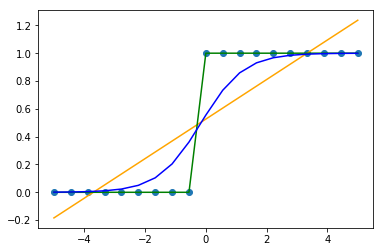

In [115]:
fig, ax = plt.subplots(1, 1)

def sigmoid(x): return 1 / (1 + np.exp(-x))

ax.scatter(X.values, y)
ax.plot(X.values, lr.predict(X), c='orange')
ax.plot(X.values, logr.predict(X), c='green')
y_ = logr.predict(X.values)
y_ = X.values * logr.coef_[0] + logr.intercept_
#print(y_)
odds = np.exp(y_).ravel()
print(f"odds {odds}")
p = odds / (1 + odds)
print(f"p {p}")
ax.plot(X.values, sigmoid(y_), c='blue')
#ax.plot(X.values, (expit(lr.predict(X))), c='maroon')

#ax.legend()
plt.show()

In [108]:
lr.coef_[0], logr.coef_[0]

(0.14210526315789468, array([1.4250863]))

In [109]:
lr.intercept_, logr.intercept_

(0.5263157894736842, array([0.22106885]))

In [104]:
lr2 = LinearRegression()
lr2.fit(X, y)

array([0.42813272, 0.44322833, 0.45842952, 0.47370848, 0.48903685,
       0.50438585, 0.5197266 , 0.53503023, 0.5502682 , 0.56541241,
       0.5804355 , 0.59531096, 0.61001337, 0.62451854, 0.63880366,
       0.6528474 , 0.66663006, 0.68013363, 0.69334183])